In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torch.utils.data as datas
from torchsummary import summary

from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

#print(os.listdir("./"))

## Function for showing dataset in graph

In [2]:
def showData(col,row,train):
    print(train)
    fig = plt.figure(figsize=(15,15))
    plt.title('Random Images From Train Dataset',loc='left')
    #plt.rcParams['axex.titlepad'] = 10
    for i in range(1,col*row + 1):
        rand_label = np.random.randint(len(train))
        img = train[rand_label][0][0,:,:]
        fig.add_subplot(row,col,i)
        fig.set_figheight(15)
        fig.set_figwidth(15)
        if train[rand_label][1] == 1:
            plt.title(str(train[rand_label][1])+ ': NORMAL')
        else:
            plt.title(str(train[rand_label][1])+ ': PNEUMONIA')
        plt.axis('off')
        plt.imshow(img, cmap='gray')
    print("0: NORMAL")
    print("1: PNEUMONIA")
    plt.show()

## Transform images

In [3]:
EPOCHS = 2
BATCH_SIZE = 3
LEARNING_RATE = 0.003
TRAIN_DATA_PATH = "../xray/train/"
TEST_DATA_PATH = "../xray/test_copy/"
VAL_DATA_PATH = "../xray/val/"
save_file_name = 'vgg16-chest-4.pt'
checkpoint_path = 'vgg16-chest-4.pth'
"""
Statistics Based on ImageNet Data for Normalization
    
Data augmentation in image transformations
"""
TRANSFORM_IMG = {
                'train': 
                transforms.Compose([
                    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                    transforms.RandomRotation(degrees=15),
                    transforms.ColorJitter(),
                    transforms.RandomHorizontalFlip(),
                    transforms.CenterCrop(size=224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])
                        ]),
                'val':
                transforms.Compose([
                    transforms.Resize(size=256),
                    transforms.CenterCrop(size=224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ]),
                'test':
                transforms.Compose([
                    transforms.Resize(size=256),
                    transforms.CenterCrop(size=224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ]),
                }

In [4]:
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG['train'])
train_data_loader = datas.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG['test'])
test_data_loader  = datas.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_data = torchvision.datasets.ImageFolder(root=VAL_DATA_PATH, transform=TRANSFORM_IMG['val'])
val_data_loader  = datas.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))
print("Number of validation samples: ", len(val_data))
print("Detected Classes are: ", train_data.class_to_idx) 

Number of train samples:  5216
Number of test samples:  462
Number of validation samples:  16
Detected Classes are:  {'NORMAL': 0, 'PNEUMONIA': 1}


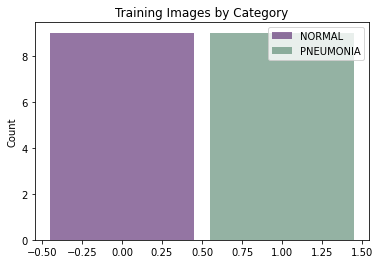

In [5]:
count_normal = 0
count_pne    = 0
    
path, dirs, files = next(os.walk("../xray/val/NORMAL"))
count_normal      = file_count = len(files)
    
path, dirs, files = next(os.walk("../xray/val/PNEUMONIA"))
count_pne         = file_count = len(files)
    
barWidth  = 0.9
bar1      = [count_normal]
bar2      = [count_pne]
bar3 = bar1 + bar2
r1        = [0]
r2        = [1]
r3        = r1 + r2
plt.ylabel('Count')
plt.title('Training Images by Category')    
plt.bar(r1, bar1, width = barWidth, color = (0.3,0.1,0.4,0.6), label='NORMAL')
plt.bar(r2, bar2, width = barWidth, color = (0.3,0.5,0.4,0.6), label='PNEUMONIA')
plt.legend()
plt.show()

In [6]:
    model = torchvision.models.vgg16(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False
    n_inputs = model.classifier[6].in_features

    # Add on classifier
    model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, 2), nn.LogSoftmax(dim=1))
    """
    model information on classification unit (not the feature extractor)
    """
    print(model.classifier)
    
    total_params = sum(p.numel() for p in model.parameters())
    print('Number of Parameters: {}'.format(total_params))
    total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
    print('Number of Training Parameters: {}'.format(total_trainable_params))
    
    """
    Data to CUDA device
    """
    
    CUDA = torch.cuda.is_available()
    if CUDA:    
        model = model.cuda()
        
    print(40*"-")
    
    print(summary(model, input_size=(3, 224, 224), batch_size=BATCH_SIZE, device='cuda'))
    """
    This is the image size in the VGGNet Paper (Simonyan et al., 2014)
    arXiv:
        abs: https://arxiv.org/abs/1409.1556
        pdf: https://arxiv.org/pdf/1409.1556.pdf
    """
    #%%
    
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters())
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    torch.cuda.empty_cache()

    valid_max_acc = 0
    history = []

    try:
        print('Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0

    overall_start = timer()

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
    (4): LogSoftmax(dim=1)
  )
)
Number of Parameters: 135309890
Number of Training Parameters: 1049346
----------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [3, 64, 224, 224]           1,792
              ReLU-2          [3, 64, 224, 224]               0
            Conv2d-3          [3, 64, 224, 224]          36,928
              ReLU-4          [3, 64, 224, 224]               0
         M

In [7]:
for epoch in range(EPOCHS):
        print(epoch,"/",EPOCHS)
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        model.train()
        start = timer()

        for ii, (data, target) in enumerate(val_data_loader):
            #print("data", ii)
            if CUDA:
                data, target = data.cuda(), target.cuda()


            optimizer.zero_grad()
            torch.cuda.empty_cache()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not CUDA else np.squeeze(correct_tensor.cpu().numpy())
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

            #print('Epoch: {epoch}\t{100 * (ii + 1) / len(train_data_loader):.2f} complete. {timer() - start:.2f} seconds elapsed in epoch.')
            print('Epoch:', epoch, " ", 100 * (ii + 1) / len(train_data_loader), " ", timer() - start, "seconds elapsed in epoch")
            #print(100 * (ii + 1) / len(train_data_loader))
            #print(timer() - start)

        else:
            #print("here")
            #print(model)
            #model.epochs += 1
            with torch.no_grad():
                model.eval()
                for data, target in val_data_loader:
                    if CUDA:
                        data, target = data.cuda(), target.cuda()

                    output = model(data)
                    loss = criterion(output, target)
                    valid_loss += loss.item() * data.size(0)
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))

                    valid_acc += accuracy.item() * data.size(0)


                train_loss = train_loss / len(train_data_loader.dataset)
                valid_loss = valid_loss / len(val_data_loader.dataset)


                train_acc = train_acc / len(train_data_loader.dataset)
                valid_acc = valid_acc / len(val_data_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                if (epoch + 1) % 2 == 0:
                    print('Epoch:', epoch, 'Training Loss: ', train_loss, 'Validation Loss: ', valid_loss)
                    print('Training Accuracy: ', 100 * train_acc, 'Validation Accuracy: ', 100 * valid_acc)

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    torch.save(model.state_dict(), save_file_name)
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= 3:
                        print('\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
                        total_time = timer() - overall_start
                        print('{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')
                        model.load_state_dict(torch.load(save_file_name))
                        model.optimizer = optimizer
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])

0 / 2
data 0
Epoch: 0   0.05750431282346176   2.4456578689999997 seconds elapsed in epoch
data 1
Epoch: 0   0.11500862564692352   3.7124562080000008 seconds elapsed in epoch
data 2
Epoch: 0   0.1725129384703853   4.945308241999999 seconds elapsed in epoch
data 3
Epoch: 0   0.23001725129384704   6.175086801000001 seconds elapsed in epoch
data 4
Epoch: 0   0.2875215641173088   7.396951485000001 seconds elapsed in epoch
data 5
Epoch: 0   0.3450258769407706   7.859983069 seconds elapsed in epoch
1 / 2
data 0
Epoch: 1   0.05750431282346176   2.810423727 seconds elapsed in epoch
data 1
Epoch: 1   0.11500862564692352   3.981185928000002 seconds elapsed in epoch
data 2
Epoch: 1   0.1725129384703853   5.183747569000005 seconds elapsed in epoch
data 3
Epoch: 1   0.23001725129384704   6.400893171000007 seconds elapsed in epoch
data 4
Epoch: 1   0.2875215641173088   7.620995642000011 seconds elapsed in epoch
data 5
Epoch: 1   0.3450258769407706   8.077067048000004 seconds elapsed in epoch
Epoch: 1

In [8]:
model.optimizer = optimizer
total_time = timer() - overall_start
print('Best epoch: ', best_epoch,  ' with loss: ', valid_loss_min, ' and acc: ', 100 * valid_acc)
print(total_time, 'total seconds elapsed. ', total_time / (epoch), 'seconds per epoch.')
history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
eps = range(1,EPOCHS-1)

Best epoch:  1  with loss:  0.3307494120672345  and acc:  93.75000037252903
112.868767682 total seconds elapsed.  112.868767682 seconds per epoch.


## Visualizing results...

loss_train
 <class 'pandas.core.series.Series'>
loss_test
 0    0.484607
1    0.488342
2    0.340475
3    0.199853
Name: valid_loss, dtype: float64
acc_train
 0    0.001150
1    0.001917
2    0.002684
3    0.002492
Name: train_acc, dtype: float64
acc_valid
 0    1.0000
1    0.6875
2    0.8125
3    1.0000
Name: valid_acc, dtype: float64
eps <class 'range'>


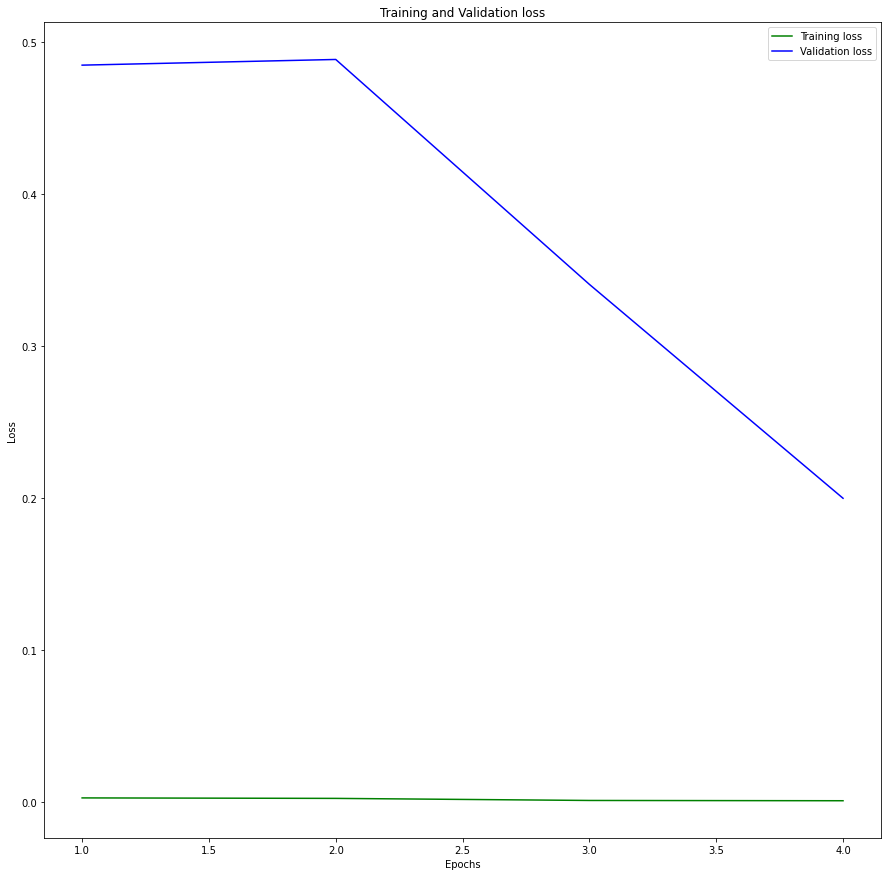

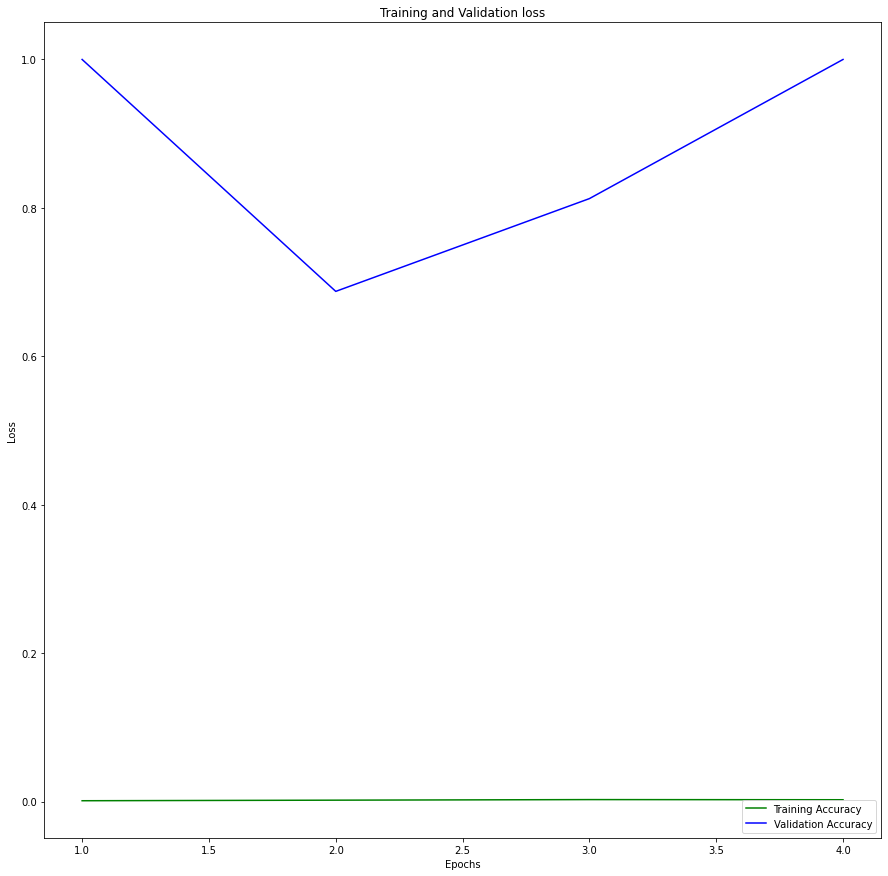

In [27]:
loss_train = history['train_loss']
loss_test = history['valid_loss']
acc_train = history['train_acc']
acc_valid = history['valid_acc']
fig = plt.figure(figsize=(15,15))

print("loss_train\n", type(loss_train))
print("loss_test\n", loss_test)
print("acc_train\n", acc_train)
print("acc_valid\n", acc_valid)

print("eps", type(eps))
eps = range(1, 5)

plt.plot(eps, loss_train, 'g', label='Training loss')
plt.plot(eps, loss_test, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() 
fig = plt.figure(figsize=(15,15))
plt.plot(eps, acc_train, 'g', label='Training Accuracy')
plt.plot(eps, acc_valid, 'b', label='Validation Accuracy')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()